<a href="https://colab.research.google.com/github/henrim666/ForexHistoricalDataCreator/blob/master/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls -sla /gdrive/'My Drive'/5MFXDB/

sqlite:////gdrive/My Drive/5MFXDB/TrainingSet002.db
112.737


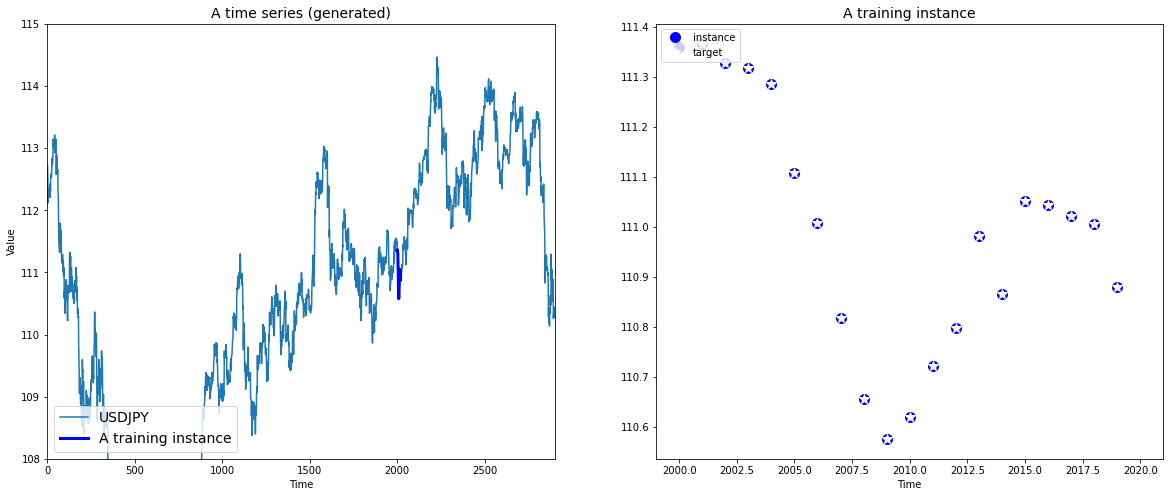

0 	MSE: 9751.85
100 	MSE: 153.28491
200 	MSE: 30.032429
300 	MSE: 0.8808691
400 	MSE: 0.019525563
500 	MSE: 0.017677344


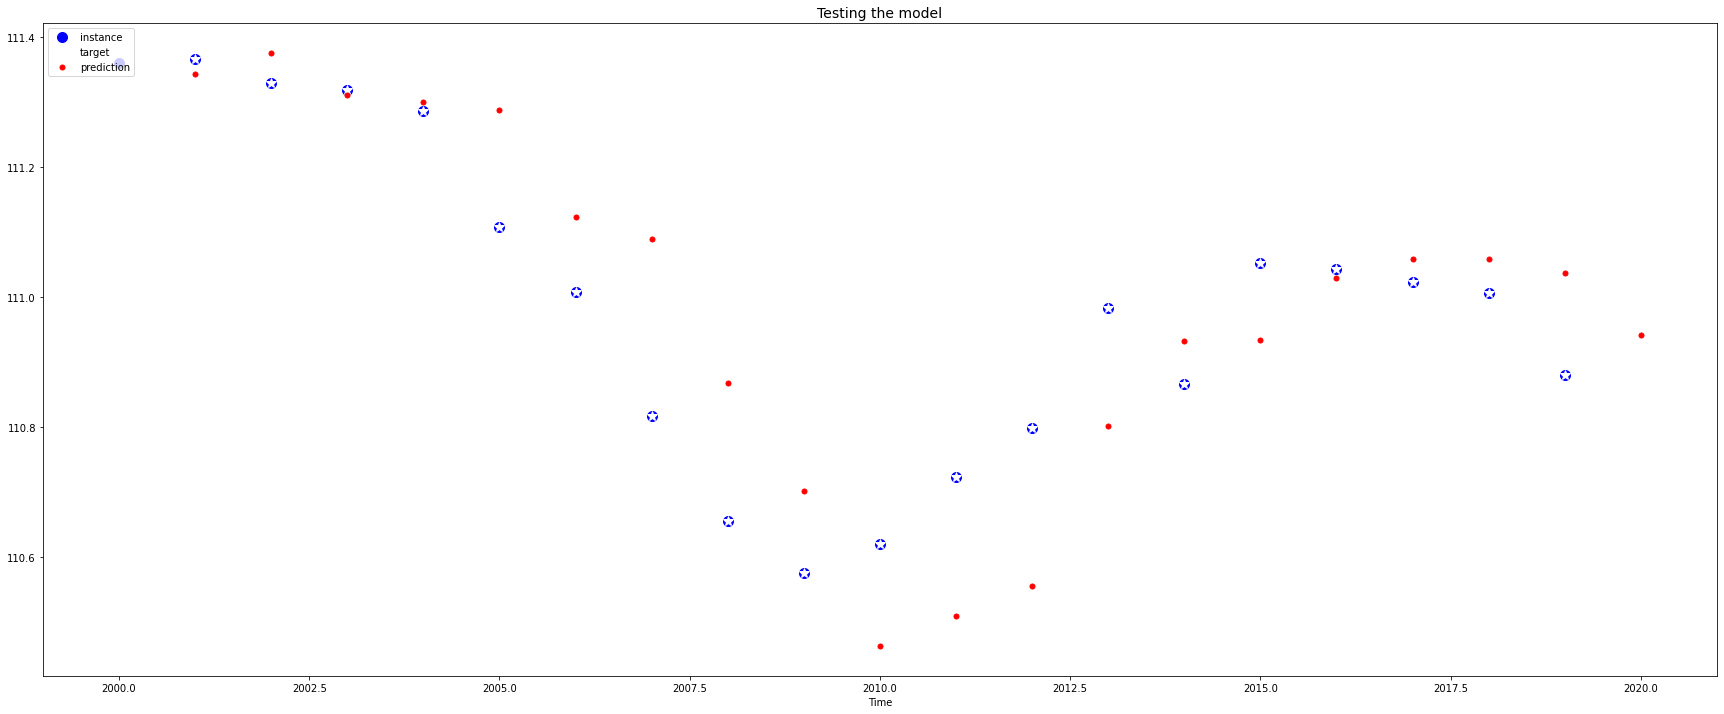

In [0]:
import tkinter as     tk
from   tkinter import *
import tkinter.font as font
from   tkinter import ttk
import PIL.Image
import PIL.ImageTk
from   bs4 import BeautifulSoup
import requests
import csv
import sqlite3
from   zipfile import ZipFile
import time
from   datetime import timedelta,datetime
import calendar
import pandas as pd
pd.set_option('mode.chained_assignment', None)

from   matplotlib.backends.backend_tkagg import (
       FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from   matplotlib.backend_bases import key_press_handler
from   matplotlib.figure import Figure
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from   matplotlib.widgets import TextBox

import os
from   multiprocessing.pool import CLOSE
from   tkinter.scrolledtext import ScrolledText
import logging
import queue
from   matplotlib.testing.jpl_units import day
#from   .plotting import register_matplotlib_converters
import plotly as py
from   plotly import subplots
import plotly.graph_objects as go
import numpy as np
#from    import stats
import scipy.optimize
from   scipy.optimize import OptimizeWarning
import warnings
import math
from   sklearn.linear_model import LinearRegression
import numpy as np
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
import statistics
import datetime
import tensorflow as tf

# Database connector
engine_type             = "sqlite:///"
databasedir             = '/gdrive/My Drive/5MFXDB/'
databasename1            = "TrainingSet002"
databasefileextension   = ".db"
engineSTR1=engine_type+databasedir+databasename1+databasefileextension
print(engineSTR1)
engine1 = create_engine(engineSTR1)

command1="""SELECT * FROM TrainingSet2018newY """ 
FXTrainingSets = pd.read_sql_query(command1, engine1)
print(float(FXTrainingSets.iloc[1]['high']))

t_min, t_max = 1, 2900
n_steps = 20
instance = 2000
n_inputs = 1
n_neurons = 100
n_outputs = 1
learning_rate = 0.001
n_iterations = 600 #1500
batch_size = 20  #50

t = np.linspace(t_min, t_max, num=t_max)
t_instance = np.linspace(instance, instance+n_steps, n_steps+1)

SelectedData='low'
traininglengthsample=t_max+n_steps
FXTrainingSet=pd.DataFrame(columns=[SelectedData])
FXTrainingSet[SelectedData]=FXTrainingSets[SelectedData].tail(traininglengthsample)
FXTrainingSet=FXTrainingSet.reset_index(drop=True)

def time_series(t): # for plots !!
    ys = []
    for dataset in t:
      tradenumber=int(dataset)
      FXprice=float(FXTrainingSet[SelectedData].loc[tradenumber])
      ys.append(FXprice)
    return np.array(ys)

def time_series_new(t): # for end plots !!
    Yaxis=[]
    ys11 = []
    ys = []
    for dt in t:
      for dataset in dt:
        for data in dataset:
          yy=[]
          FXprice=float(FXTrainingSet[SelectedData].loc[data])
          yy.append(FXprice)
        ys11.append(yy)
      ys.append(ys11)    
    return np.array(ys)

def time_series_batch(t): # for tesnorflow !! call with NEXT BATCH!!
    Yaxis=[]
    for dt in t:
      ys = []
      for dataset in dt:
        FXprice=float(FXTrainingSet[SelectedData].loc[dataset])
        ys.append(FXprice)
      Yaxis.append(ys)   
    return np.array(Yaxis)

def next_batch(batch_size, n_steps):
    ys1=[]
    for samplesets in np.random.randint(t_min,t_max-n_steps,batch_size):
      ys1.append(samplesets + np.arange(0., n_steps + 1))
    ys=time_series_batch(ys1)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"USDJPY")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, t_max, 108,115])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

#start neuron model
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
#end neuron model

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series_new(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")
#time_series_new > time_series error
plt.figure(figsize=(30,12))
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:],  time_series(t_instance[1:]) , "w*", markersize=10, label="target")
plt.plot(t_instance[1:],  y_pred[0,:,0]                   , "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

In [0]:
FXTrainingSets

,level_0,DateTime,MACD,MACDhigh,MACDtrade,MAVG200tech,MAVG20tech,MAVG288,MAVG48,MAVG52tech,MAVG6,MAVGcross,MVAGOrder,OpenMarkets,RSI1,RSI2,RSIhigh,RSIhighOrder,RSItrade,RSItradeOrder,STD200tech,STD20tech,STD52tech,angle,candletotalcount,close,crosstype,exp1,exp2,exp3,high,index,innerhigh,innerlow,low,ma156,ma16,ma4,max156,max16,max4,maxhighdistance,maxlowdistance,min156,min16,min4,open,portvalue,r1,r2,r3,s1,s2,s3,shares,std156,std16,std4,surfaceabove,ticker,timestamp,trade,tradecolor,tradecut,tradelength,tradeprofit
0,35,736696.413305,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,,,T,0.000000,0.000000,0.000000,,0.000000,,0.000000,0.000000,0.000000,7275.224240,35.0,112.734,01.0crosss16std4-1.0cross4std1560-1.0cros16std...,0.000000,0.000000,0.000000,112.768,35.0,112.789,112.576,112.721,26.006179,112.758687,112.75600,112.782,112.782,112.768,-9999.000000,9999.000000,0.000,112.730,112.734,112.768,"2018-01-02 09:55:00.000000 : Stock value: 0.0,...",0.000,0.000,0.000,0.000,0.000,0.000,0.0,47.480582,0.015300,0.013038,-9999.0000,USDJPY,2018-01-02 09:55:00.000000,112.734,lightgrey,112.711,32.0,112.868
1,87,736696.590278,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,,,,0.000000,0.000000,0.000000,,0.000000,,0.000000,0.000000,0.000000,0.112345,51.0,112.735,0-1.0crosss16std401.0crosss16std40-1.0crosss16...,0.000000,0.000000,0.000000,112.737,87.0,112.752,112.659,112.715,63.574731,112.713437,112.71775,112.782,112.735,112.735,-0.000020,-0.000980,0.000,112.695,112.707,112.719,"2018-01-02 14:10:00.000000 : Stock value: 0.0,...",0.000,0.000,0.000,0.000,0.000,0.000,0.0,55.885319,0.010446,0.010894,-0.0250,USDJPY,2018-01-02 14:10:00.000000,112.735,lightgrey,112.705,32.0,112.837
2,110,736696.670142,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,,,,0.000000,0.000000,0.000000,,0.000000,,0.000000,0.000000,0.000000,-29.428937,22.0,112.622,01.0crosss16std401.0crosss16mav4-1.0crosss16st...,0.000000,0.000000,0.000000,112.660,110.0,112.736,112.623,112.623,80.188571,112.670375,112.65350,112.782,112.704,112.667,0.107864,0.005136,0.000,112.622,112.622,112.660,"2018-01-02 16:05:00.000000 : Stock value: 0.0,...",0.000,0.000,0.000,0.000,0.000,0.000,0.0,51.057242,0.018114,0.018364,1.1865,USDJPY,2018-01-02 16:05:00.000000,112.622,lightgrey,112.613,32.0,112.760
3,126,736696.725698,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,,,L,0.000000,0.000000,0.000000,,0.000000,,0.000000,0.000000,0.000000,-46.217593,15.0,112.501,01.0crosss16std40-1.0crosss16std4,0.000000,0.000000,0.000000,112.567,126.0,112.682,112.499,112.499,91.738705,112.613812,112.56775,112.782,112.659,112.606,0.112933,0.008067,0.000,112.501,112.501,112.563,"2018-01-02 17:25:00.000000 : Stock value: 0.0,...",0.000,0.000,0.000,0.000,0.000,0.000,0.0,43.837925,0.037343,0.041972,0.8470,USDJPY,2018-01-02 17:25:00.000000,112.501,lightgrey,112.489,32.0,112.667
4,187,736696.937511,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,,,N,0.000000,0.000000,0.000000,,0.000000,,0.000000,0.000000,0.000000,-35.713907,60.0,112.127,01.0crosss16std40-1.0cros16mav156-1.0cross4mav...,0.000000,0.000000,0.000000,112.158,187.0,112.503,112.117,112.118,112.509827,112.158125,112.14425,112.768,112.179,112.158,0.367767,0.006233,112.126,112.127,112.127,112.158,"2018-01-02 22:30:00.000000 : Stock value: 0.0,...",0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.231651,0.013157,0.011300,11.0330,USDJPY,2018-01-02 22:30:00.000000,112.127,lightgrey,112.108,32.0,112.258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,75894,737059.621588,-0.005589,0.005589,0.005589,110.308585,110.41170,110.284878,110.422458,110.424577,110.406000,,BRG1BRG2,,0.399861,0.666667,0.901961,GRB,0

In [0]:
!ls -sla


total 232
  4 drwxr-xr-x 1 root root   4096 Mar 18 13:48 .
  4 drwxr-xr-x 1 root root   4096 Mar 18 13:03 ..
  4 -rw-r--r-- 1 root root     97 Mar 18 13:48 checkpoint
  4 drwxr-xr-x 1 root root   4096 Mar 12 16:14 .config
124 -rw-r--r-- 1 root root 123620 Mar 18 13:48 my_time_series_model.data-00000-of-00001
  4 -rw-r--r-- 1 root root    510 Mar 18 13:48 my_time_series_model.index
 84 -rw-r--r-- 1 root root  84467 Mar 18 13:48 my_time_series_model.meta
  4 drwxr-xr-x 1 root root   4096 Mar  3 18:11 sample_data


https://stackoverflow.com/questions/52582275/tf-data-with-multiple-inputs-outputs-in-keras

https://github.com/ageron/handson-ml/blob/master/14_recurrent_neural_networks.ipynb
